# Import packages

In [1]:
import math, os, collections
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from evaluation import Evaluation
from db_connection.utils import get_conn, get_data_start_dt
from utils_load import load_w103, load_w106, load_cust, cust_process
from mlaas_tools.config_build import config_set

In [2]:
## Configure env
if not os.path.isfile('config.ini'):
    config_set()

In [3]:
## Load db connection
rawdata_conn = get_conn('edu')

read key file
login as edu-cytsao


# fund feature preprocess (w106)

In [4]:
sql = """SELECT * FROM sinica.witwo106"""
fund = pd.read_sql(sql, rawdata_conn)
fund.head()

,channel_callcenter_ind,channel_frontdesk_ind,channel_mobile_ind,channel_web_ind,counterparty_code,etl_dt,fee_rate,fee_type_code,high_yield_bond_ind,invest_limited_code,invest_type,isin_code,mkt_rbot_ctg_ic,prod_ccy,prod_detail_type_code,prod_name,prod_risk_code,prod_type_code,wm_prod_code
0,YYYYY,YYYYY,YYYYY,YYYYY,AA,2019-10-17,0.03,A,N,AA,F01,LU1005136848,F0201,AUD,FNDF,富達全球入息基金Ｈ月配澳幣避險,RR3,04,AAC4
1,NNYYN,NYYYN,NYYYN,NYYYN,AD,2019-10-17,0.00,B,Y,AD,F02,LU1013768343,F1301,USD,FNDF,聯博歐洲收益基金ＢＡ穩定月配美元避險,RR3,04,AD70
2,NNNNN,NNNNN,NNNNN,NNNNN,AF,2019-10-17,0.03,A,N,AF,F01,LU0271656307,F0102,EUR,FNDF,鋒匯理Ⅱ－歐洲潛力Ａ２歐元,RR4,04,AF46
3,YYYYY,YYYYY,YYYYY,YYYYY,AO,2019-10-17,0.02,A,N,AO,F02,IE00B0M2Y900,F1201,USD,FNDF,ＰＩＭＣＯ總回報債券基金Ｅ級類別收息股份,RR2,04,AO14
4,NNNNN,NNNNN,NNNNN,NNNNN,CC,2019-10-17,0.03,A,N,CC,F01,,F0105,JPY,FNDF,Ｆ日本槓桿基金,RR2,04,CC13


In [28]:
fund = load_w106(rawdata_conn)
fund.head()

,wm_prod_code,can_rcmd_ind,high_yield_bond_ind,counterparty_code,invest_limited_code,invest_type,mkt_rbot_ctg_ic,prod_ccy,prod_detail_type_code,prod_risk_code
0,AAC4,1,N,AA,AA,F01,F0201,AUD,FNDF,RR3
1,AD70,0,Y,AD,AD,F02,F1301,USD,FNDF,RR3
2,AF46,0,N,AF,AF,F01,F0102,EUR,FNDF,RR4
3,AO14,1,N,AO,AO,F02,F1201,USD,FNDF,RR2
4,CC13,0,N,CC,CC,F01,F0105,JPY,FNDF,RR2


In [6]:
len(fund)

4169

In [7]:
fund.describe(include='object')

,wm_prod_code,high_yield_bond_ind,counterparty_code,invest_limited_code,invest_type,mkt_rbot_ctg_ic,prod_ccy,prod_detail_type_code,prod_risk_code
count,4169,4169,4169,4169,4169,4169,4169,4169,4169
unique,4169,2,162,156,6,53,14,2,5
top,3716,N,CC,CC,F01,F0801,USD,FNDF,RR3
freq,1,2837,155,155,2103,552,1825,2608,1541


In [8]:
fund.isna().sum()
# no NA value

wm_prod_code             0
can_rcmd_ind             0
high_yield_bond_ind      0
counterparty_code        0
invest_limited_code      0
invest_type              0
mkt_rbot_ctg_ic          0
prod_ccy                 0
prod_detail_type_code    0
prod_risk_code           0
dtype: int64

In [9]:
fund[fund['counterparty_code']!=fund['invest_limited_code']]

,wm_prod_code,can_rcmd_ind,high_yield_bond_ind,counterparty_code,invest_limited_code,invest_type,mkt_rbot_ctg_ic,prod_ccy,prod_detail_type_code,prod_risk_code
29,WL11,0,Y,WL,BB,F02,F1502,USD,FNDF,RR3
42,II11,0,N,II,EE,F01,F0301,USD,FNDF,RR5
43,II13,0,N,II,EE,F01,F0101,USD,FNDF,RR1
44,II25,0,N,II,EE,F01,F0404,USD,FNDF,RR5
82,MM12,0,N,MM,BB,F01,F0102,EUR,FNDF,RR3
...,...,...,...,...,...,...,...,...,...,...
4047,MM18,0,N,MM,BB,F01,F0903,EUR,FNDF,RR5
4048,MM19,0,N,MM,BB,F01,F0903,EUR,FNDF,RR5
4075,KK05,0,N,KK,JJ,F01,F0102,USD,FNDF,RR4
4105,AI16,0,N,AI,AJ,F01,F0401,USD,FNDF,RR5


In [29]:
fund[fund['high_yield_bond_ind']=='N']['invest_type'].value_counts()

F01    2084
F02     381
F03     218
F04      72
F05      50
F06      32
Name: invest_type, dtype: int64

In [30]:
fund[fund['high_yield_bond_ind']=='Y']['invest_type'].value_counts()
# 高收益這個指標跟風險收益等級看起來不重複 -> 保留

F02    1000
F03     250
F05      63
F01      19
Name: invest_type, dtype: int64

In [11]:
#fund.to_csv('fund_w106.csv')

## features with number of categories > 10

In [12]:
fund['counterparty_code'].value_counts()[:10]
# discard count < 100
# ['CC', 'AA', 'AF', 'AG', 'NN', 'KK', 'AD', 'PP']

CC    155
AA    146
AF    142
AG    142
NN    126
KK    112
AD    101
PP    100
UF     88
BF     69
Name: counterparty_code, dtype: int64

In [13]:
fund.loc[fund['counterparty_code'].value_counts()[fund['counterparty_code']].values<100, 'counterparty_code'] = 'other'
fund['counterparty_code'].value_counts()

other    3145
CC        155
AA        146
AG        142
AF        142
NN        126
KK        112
AD        101
PP        100
Name: counterparty_code, dtype: int64

In [14]:
fund['mkt_rbot_ctg_ic'].value_counts()[:10]

F0801    552
F0201    331
F0101    308
F1501    265
F0102    245
F1301    179
F1404    172
F1201    171
F1402    169
F0409    162
Name: mkt_rbot_ctg_ic, dtype: int64

In [15]:
fund['prod_ccy'].value_counts()[:10]

USD    1825
TWD     919
EUR     546
CNY     280
AUD     276
ZAR     170
JPY      44
GBP      43
NZD      16
SGD      14
Name: prod_ccy, dtype: int64

In [16]:
def w106_process(df):
    # discard categorization
    discard_condition = {'counterparty_code': 100, 'mkt_rbot_ctg_ic': 200, 'prod_ccy': 500}
    for col, n in discard_condition.items(): 
        df.loc[df[col].value_counts()[df[col]].values<n, col] = col+'_other'
    # convert int to categorical
    df['high_yield_bond_ind'] = df['high_yield_bond_ind'].map({'Y': 'high_yield', 'N': 'not_high_yield'})
    df['can_rcmd_ind'] = df['can_rcmd_ind'].map({1:'can_rcmd', 0: 'can_rcmd_N'})
    del df['invest_limited_code']
    return df

In [17]:
w106_process(fund)

,wm_prod_code,can_rcmd_ind,high_yield_bond_ind,counterparty_code,invest_type,mkt_rbot_ctg_ic,prod_ccy,prod_detail_type_code,prod_risk_code
0,AAC4,can_rcmd,not_high_yield,AA,F01,F0201,prod_ccy_other,FNDF,RR3
1,AD70,can_rcmd_N,high_yield,AD,F02,mkt_rbot_ctg_ic_other,USD,FNDF,RR3
2,AF46,can_rcmd_N,not_high_yield,AF,F01,F0102,EUR,FNDF,RR4
3,AO14,can_rcmd,not_high_yield,other,F02,mkt_rbot_ctg_ic_other,USD,FNDF,RR2
4,CC13,can_rcmd_N,not_high_yield,CC,F01,mkt_rbot_ctg_ic_other,prod_ccy_other,FNDF,RR2
...,...,...,...,...,...,...,...,...,...
4164,4826,can_rcmd,high_yield,other,F02,F1501,prod_ccy_other,FNDD,RR3
4165,WD12,can_rcmd_N,not_high_yield,other,F02,mkt_rbot_ctg_ic_other,prod_ccy_other,FNDF,RR3
4166,5929,can_rcmd,not_high_yield,other,F03,F0801,prod_ccy_other,FNDD,RR3
4167,AV04,can_rcmd_N,high_yield,other,F02,F1501,USD,FNDF,RR3


# user features

In [4]:
conn = get_conn('edu')
sql = 'SELECT * FROM sinica.cm_customer_m LIMIT 100'
user = pd.read_sql(sql, conn)
user

read key file
login as edu-cytsao


,age,birth_dt,biz_line_code,cc_cust_level,children_cnt,country_code,cust_no,cust_start_dt,cust_status_code,cust_vintage,...,gender_code,house_own_type_code,income_range_code,marital_status_code,nation_code,personal_income,position_code,risk_type_code,wm_club_class_code,work_years
0,39.0,None,P,C,0.0,TW,00037XyHw6gCpfprSvwkIA==,2002-09-27,b,168.0,...,F,None,1,1,1,2877612.0,4,None,0,0.0
1,22.0,None,P,None,0.0,TW,0006I16et6ufcHqydtToEA==,2015-10-15,b,11.0,...,F,None,1,None,1,0.0,None,None,0,NaN
2,66.0,None,P,B,0.0,TW,0006Yu+Cuau6B/zanFuVww==,2002-02-26,b,175.0,...,M,None,2,1,1,7534966.0,2,None,0,0.0
3,53.0,None,P,C,0.0,None,0007wlKnxbcsRl0ucBEX6g==,2002-07-17,00,170.0,...,F,None,1,2,1,0.0,5,None,None,0.0
4,68.0,None,P,C,0.0,TW,0008KHI9QOE+RGzdkLi/1g==,1999-03-25,b,210.0,...,F,None,1,1,1,0.0,5,None,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,35.0,None,P,None,NaN,TW,003pi3tN5mPKAnn34p/MxQ==,2004-09-01,b,144.0,...,M,None,None,None,1,NaN,None,None,0,NaN
96,22.0,None,P,None,0.0,TW,003/qboBhoYXihiYYe284A==,2007-02-08,b,115.0,...,F,None,1,None,1,0.0,None,None,0,NaN
97,39.0,None,P,C,1.0,TW,003sy/eZ/P7sfhhZUPxtng==,2004-12-13,55,141.0,...,F,None,1,1,1,1938360.0,5,None,0,0.0
98,41.0,None,P,None,NaN,TW,0/03TePkuLmCu77pWiFV+g==,2000-07-03,b,194.0,...,M,None,1,None,1,0.0,None,None,0,NaN


In [5]:
print(user.columns)
len(user.columns)

Index(['age', 'birth_dt', 'biz_line_code', 'cc_cust_level', 'children_cnt',
       'country_code', 'cust_no', 'cust_start_dt', 'cust_status_code',
       'cust_vintage', 'data_ym', 'debt_nego_code', 'edu_code', 'etl_dt',
       'gender_code', 'house_own_type_code', 'income_range_code',
       'marital_status_code', 'nation_code', 'personal_income',
       'position_code', 'risk_type_code', 'wm_club_class_code', 'work_years'],
      dtype='object')


24

In [6]:
user.describe(include=object)

,birth_dt,biz_line_code,cc_cust_level,country_code,cust_no,cust_start_dt,cust_status_code,data_ym,debt_nego_code,edu_code,etl_dt,gender_code,house_own_type_code,income_range_code,marital_status_code,nation_code,position_code,risk_type_code,wm_club_class_code
count,0,100,64,86,100,100,100,100,86,68,100,100,2,86,72,100,65,7,86
unique,0,1,5,2,100,93,4,1,2,6,1,2,2,4,2,2,3,3,3
top,NaN,P,C,TW,001lor7CjXknLam7eFrqiA==,2004-08-09,b,2016-09-01,b,5,2016-10-03,F,3,1,1,1,5,03,0
freq,NaN,100,38,85,1,5,77,100,85,24,100,62,1,81,36,99,29,3,84


In [7]:
user.describe()

,age,children_cnt,cust_vintage,personal_income,work_years
count,100.00000,85.000000,100.00000,8.600000e+01,65.000000
mean,41.09000,0.082353,119.92000,5.102941e+06,1.299538
std,13.09491,0.352264,70.58195,2.455527e+07,4.125164
min,0.00000,0.000000,6.00000,0.000000e+00,0.000000
25%,31.75000,0.000000,56.00000,0.000000e+00,0.000000
50%,40.50000,0.000000,133.00000,2.072062e+06,0.000000
75%,50.00000,0.000000,166.50000,3.487638e+06,0.000000
max,68.00000,2.000000,294.00000,2.262000e+08,20.000000


In [22]:
def load_cust(today, rawdata_conn=None, span=18, mode='train'):
    '''
    cte1:處理duplicates:若有一樣的cust_no留下所有欄位最大值 ; 
    '''
    if mode == 'train':
        txn_start_dt, txn_end_dt = get_data_start_dt(today, span), today  
    else: # evaluation
        after_1d_dt, after_1m_dt, after_7d_dt = get_data_dt(today, 1)
        txn_start_dt, txn_end_dt = after_1d_dt, after_1m_dt
    print('loading', txn_start_dt, txn_end_dt, 'data.')
        
    sql = """
        with
            cte0 as (select distinct cust_id as cust_no 
                     from sinica.witwo103_hist 
                    where wm_txn_code='1'and txn_dt>='{d_start}' and txn_dt<='{d_end}'), 
            cte1 as(
                select
                    cust_no,
                    etl_dt,
                    age,
                    gender_code,
                    cust_vintage,
                    income_range_code,
                    risk_type_code,
                    children_cnt,
                    edu_code,
                    wm_club_class_code,
                    row_number() over (partition by cust_no order by etl_dt desc,
                                                                     age desc,
                                                                     cust_vintage desc,
                                                                     income_range_code asc) as rank
                from sinica.cm_customer_m
                where cust_no in (select cust_no from cte0)
                )
            select cust_no,
                    age,
                    gender_code,
                    cust_vintage,
                    income_range_code,
                    risk_type_code,
                    children_cnt,
                    edu_code,
                    wm_club_class_code
                    from cte1 
                    where rank = 1
        """.format(d_start=txn_start_dt, d_end=txn_end_dt)
    cust_df = pd.read_sql(sql, rawdata_conn)
    #cust_df = cust_process(cust_df)
    return cust_df

In [17]:
def load_cust1(today, rawdata_conn=None, span=18, mode='train'):
    '''
    cte1:處理duplicates:若有一樣的cust_no留下所有欄位最大值 ; 
    '''
    if mode == 'train':
        txn_start_dt, txn_end_dt = get_data_start_dt(today, span), today  
    else: # evaluation
        after_1d_dt, after_1m_dt, after_7d_dt = get_data_dt(today, 1)
        txn_start_dt, txn_end_dt = after_1d_dt, after_1m_dt
    print('loading', txn_start_dt, txn_end_dt, 'data.')
        
    sql = """
                with
                    cte0 as (select distinct cust_id as cust_no 
                             from sinica.witwo103_hist 
                            where wm_txn_code='1'and txn_dt>='{d_start}' and txn_dt<='{d_end}'),
                    cte1 as(
                        select distinct
                            cust_no,
                            gender_code,
                            age,
                            income_range_code,
                            position_code,
                            edu_code
                        from sinica.cm_customer_m
                        where cust_no in (select cust_no from cte0)
                        )
                    select cust_no,
                            gender_code,
                            age,
                            income_range_code,
                            position_code,
                            edu_code
                    from cte1
        """.format(d_start=txn_start_dt, d_end=txn_end_dt)
    cust_df = pd.read_sql(sql, rawdata_conn)
    #cust_df = cust_process(cust_df)
    return cust_df

In [23]:
conn = get_conn('edu')
cm_customer_m_df = load_cust('2018-12-31', conn, span=18)
cm_customer_m_df

read key file
login as edu-cytsao
loading 2017-07-01 2018-12-31 data.


,cust_no,age,gender_code,cust_vintage,income_range_code,risk_type_code,children_cnt,edu_code,wm_club_class_code
0,0016boFyZaRofUFAYfXYTA==,54.0,F,182.0,2,03,0.0,3,3
1,008d2RbDuEfP8n5Dc/t20Q==,53.0,F,206.0,1,03,0.0,5,0
2,00b4qBwr1FZJW6zTYLYyQA==,68.0,F,277.0,1,03,0.0,3,P
3,00CC0bunwJX3jgJwycvHvQ==,48.0,M,24.0,1,03,0.0,2,O
4,00EEcEgHkpb6NGcolnAEog==,54.0,F,266.0,3,03,0.0,5,O
...,...,...,...,...,...,...,...,...,...
73584,ZZXAkIEU4xzGE95pBRb6sg==,71.0,F,179.0,1,03,0.0,6,0
73585,ZZxyMyqVHotFQNSe1O8rqw==,18.0,M,52.0,1,04,0.0,6,0
73586,ZzYD6HPVyldQFpsaCR5/Hg==,52.0,M,328.0,2,03,0.0,3,Q
73587,+Zzz53zCPHD9ULeoCsmFpg==,43.0,M,199.0,1,03,0.0,3,0


In [20]:
len(cm_customer_m_df.cust_no.unique())

73589

In [21]:
user_fea_lst = cm_customer_m_df.drop_duplicates(subset=['cust_no'], keep='last', ignore_index=True).values.tolist()
print(len(user_fea_lst))

73589


In [24]:
print(len(set(cm_customer_m_df.cust_no)))

73589


In [6]:
cm_customer_m_df.isna().sum()

cust_no                 0
age                     0
gender_code           179
cust_vintage            0
income_range_code      36
risk_type_code          3
children_cnt            0
edu_code                1
wm_club_class_code      0
dtype: int64

In [29]:
cv_bin = pd.cut(cm_customer_m_df['cust_vintage'], bins=list(range(0, 350, 20)))#, labels=False)

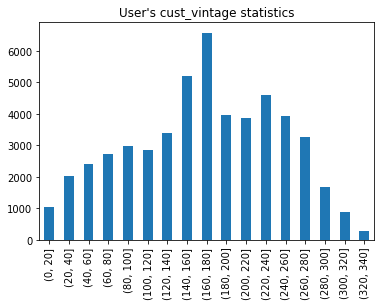

In [34]:
cv_bin.value_counts().sort_index().plot.bar(title="User's cust_vintage statistics")


In [7]:
cust_df_ = cust_process(cm_customer_m_df)
cust_df_

,cust_no,age,gender_code,cust_vintage,income_range_code,risk_type_code,children_cnt,edu_code,wm_club_class_code
0,00EEcEgHkpb6NGcolnAEog==,3.0,F,2.0,3,03,0.0,5,O
1,00FmcV87beY8s7OI0Xjtkg==,2.0,F,2.0,2,03,0.0,4,Q
2,00IrxuhcWjiKQPXJDBv2Yg==,2.0,M,2.0,1,04,0.0,3,0
3,00lTKmRASDOVClTRY15HIw==,1.0,F,0.0,1,03,0.0,6,0
4,00qPHDE+5ykU4RA/Ce18Pw==,3.0,F,1.0,1,04,0.0,4,3
...,...,...,...,...,...,...,...,...,...
51743,zzWk36PbMz3zfAcv/b0eJw==,0.0,F,0.0,1,02,0.0,6,0
51744,ZZXAkIEU4xzGE95pBRb6sg==,3.0,F,1.0,1,03,0.0,6,0
51745,ZZxyMyqVHotFQNSe1O8rqw==,0.0,M,0.0,1,04,0.0,6,0
51746,+Zzz53zCPHD9ULeoCsmFpg==,2.0,M,1.0,1,03,0.0,3,0


In [8]:
cust_df_.isna().sum()

cust_no               0
age                   0
gender_code           0
cust_vintage          0
income_range_code     0
risk_type_code        0
children_cnt          0
edu_code              0
wm_club_class_code    0
dtype: int64

In [14]:
cust_df_.children_cnt.value_counts()

0.0    50417
2.0      713
1.0      300
3.0      235
4.0       83
Name: children_cnt, dtype: int64

In [11]:
cm_customer_m_df.wm_club_class_code.value_counts()

0    28931
Q     5939
Z     4600
P     3969
O     3283
3     1229
M     1172
1     1077
N      822
2      436
H       94
4       83
F       67
I       17
J       16
G       13
Name: wm_club_class_code, dtype: int64

In [12]:
cm_customer_m_df.risk_type_code.value_counts()

04    25342
03    23123
02     2907
ZZ      238
4        83
01       52
Name: risk_type_code, dtype: int64

In [11]:
cm_customer_m_df.children_cnt.value_counts()

0.0     1718257
2.0       30913
1.0       13521
3.0        9843
4.0        2591
5.0         407
10.0         99
22.0         70
7.0          70
6.0          70
20.0         63
12.0         35
74.0         35
33.0         35
30.0          4
40.0          1
Name: children_cnt, dtype: int64

# Evaluation data

In [12]:
conn = get_conn('edu')
evaluation = Evaluation('2018-12-31', None, 6, None)
evaluate_w103 = evaluation.read('2018-12-31', conn, 6)

read key file
login as edu-cytsao
read key file
login as edu-cytsao


In [13]:
evaluate_w103

,cust_no,wm_prod_code
0,00ugL9CAflI4eVOrkUVKDg==,FE41
1,01y+bQfqgDv4jaKluGNzJg==,AG23
2,02wYCJa+FZ51NXzlZx6oBQ==,ED64
3,03oAsRwG9EttbqNCNYqmkQ==,KK41
4,03ZyLI0fXpZ7Nor9qNgK0w==,CCB6
...,...,...
5416,+zyVGaPHp1w9MVYLHGQPSA==,AW01
5417,ZzfPSKfjdZnv5yyYg3YHHA==,2152
5418,zZijdmkMLP9riddUbF778A==,KKA8
5419,zzOnaWQ8v9wgoMPXdIC63A==,BB01


In [14]:
len(evaluate_w103.cust_no.unique())

3883

## get evaluation user features

In [5]:
conn = get_conn('edu')
eva_cust_df = load_cust('2018-12-31', conn, span=None, mode='evaluation')
eva_cust_df

read key file
login as edu-cytsao
loading 2019-01-01 2019-01-31 data.


,cust_no,age,gender_code,cust_vintage,income_range_code,risk_type_code,children_cnt,edu_code,wm_club_class_code
0,00FmcV87beY8s7OI0Xjtkg==,2.0,F,2.0,2,03,0.0,4,Q
1,00qPHDE+5ykU4RA/Ce18Pw==,3.0,F,1.0,1,04,0.0,4,3
2,/00rG/y1/402L1woM8tdmA==,2.0,F,2.0,2,04,0.0,4,0
3,00roz6dL8l5Ouk54dlOc9A==,3.0,F,2.0,4,04,0.0,5,M
4,00ugL9CAflI4eVOrkUVKDg==,3.0,M,2.0,1,03,0.0,6,O
...,...,...,...,...,...,...,...,...,...
35632,ZZvWOD/9fleAE0GYNGjLPA==,3.0,F,1.0,2,04,0.0,3,Q
35633,zZWE1Zhl7DBlGFGBfXSSog==,2.0,F,2.0,1,03,0.0,6,0
35634,zzWk36PbMz3zfAcv/b0eJw==,0.0,F,0.0,1,02,0.0,6,0
35635,ZZxyMyqVHotFQNSe1O8rqw==,0.0,M,0.0,1,04,0.0,6,0


In [9]:
eva_cust_df[eva_cust_df['cust_no'].isin(evaluate_w103['cust_no'])]

,cust_no,age,gender_code,cust_vintage,income_range_code,risk_type_code,children_cnt,edu_code,wm_club_class_code
4,00ugL9CAflI4eVOrkUVKDg==,3.0,M,2.0,1,03,0.0,6,O
17,01y+bQfqgDv4jaKluGNzJg==,1.0,F,0.0,1,04,0.0,3,0
26,02wYCJa+FZ51NXzlZx6oBQ==,3.0,F,2.0,3,04,0.0,4,P
30,03oAsRwG9EttbqNCNYqmkQ==,1.0,F,0.0,1,03,0.0,4,0
38,03ZyLI0fXpZ7Nor9qNgK0w==,1.0,F,0.0,1,04,0.0,4,0
...,...,...,...,...,...,...,...,...,...
35593,+zyVGaPHp1w9MVYLHGQPSA==,3.0,M,0.0,2,04,0.0,6,Q
35611,ZzfPSKfjdZnv5yyYg3YHHA==,2.0,F,1.0,1,02,0.0,3,0
35615,zZijdmkMLP9riddUbF778A==,3.0,M,1.0,1,03,0.0,3,0
35621,zzOnaWQ8v9wgoMPXdIC63A==,2.0,F,2.0,1,04,0.0,4,0


# save data table to csv

In [6]:
import os
## Load data
exp_dates = ['2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30']
span = [18, 6]
evaluation_span = '1m'
def load_tables(date, span):
    print('\n', date, span)
    rawdata_conn = get_conn('edu')
    # interaction train w103
    w103_df = load_w103(date, rawdata_conn, span)
    # user
    cust_df = load_cust(date, rawdata_conn, span)
    print('Total users:', len(w103_df.cust_no.unique()))
    # intersection
    user_filter = set(w103_df['cust_no'].tolist()) & set(cust_df['cust_no'].tolist())
    w103_df = w103_df[w103_df['cust_no'].isin(user_filter)]
    cust_df_filter = cust_df[cust_df['cust_no'].isin(user_filter)]
    print('Total users (with features):', len(w103_df.cust_no.unique()))
    
    purchase_hist = w103_df.groupby("cust_no")["wm_prod_code"].apply(lambda x: list(set(x.values.tolist()))).to_dict()
    # evaluation w103
    evaluation = Evaluation(date, None, evaluation_span, purchase_hist)
    evaluate_w103 = evaluation.read(date, rawdata_conn, evaluation_span)
    # evaluation user features
    eva_cust_df = load_cust(date, rawdata_conn, span=None, mode='evaluation')
    # intersection
    eva_user_filter = set(evaluate_w103['cust_no'].tolist()) & set(eva_cust_df['cust_no'].tolist())
    eva_cust_df_filter = eva_cust_df[eva_cust_df['cust_no'].isin(eva_user_filter)]
    evaluate_w103 = evaluate_w103[evaluate_w103['cust_no'].isin(eva_user_filter)]

    warm_users, cold_users = evaluation.warm_cold_list()
    print('warm-users:', len(warm_users), 'cold-users:', len(cold_users))
    
    # fund
    w106_df = load_w106(rawdata_conn)
    _filter = w106_df.wm_prod_code.isin(w103_df['wm_prod_code'].tolist())
    w106_df_filter = w106_df[_filter]
    
    # save data to csv
    '''
    path = '../../raw_datasets/'+date+'_'+str(span)
    if not os.path.exists(path):
        os.makedirs(path)
    w103_df.to_csv(path+'/train_w103.csv')
    evaluate_w103.to_csv(path+'/evaluate_w103.csv')
    w106_df_filter.to_csv(path+'/item_features.csv')
    cust_df_filter.to_csv(path+'/user_features.csv')
    eva_cust_df_filter.to_csv(path+'/evaluate_user_features.csv')
    '''
    
    print('data saved!')
    

In [ ]:
print("Loading Data...")
for d in exp_dates:
    for s in span:
        load_tables(d, s)

Loading Data...

 2018-12-31 18
read key file
login as edu-cytsao
loading 2017-07-01 2018-12-31 data.
Total users: 73189
Total users (with features): 72553
read key file
login as edu-cytsao
loading 2019-01-01 2019-01-31 data.
warm-users: 3030 cold-users: 853
data saved!

 2018-12-31 6
read key file
login as edu-cytsao
loading 2018-07-01 2018-12-31 data.
Total users: 51506
Total users (with features): 51126
read key file
login as edu-cytsao
loading 2019-01-01 2019-01-31 data.
warm-users: 2579 cold-users: 1304
data saved!

 2019-01-31 18
read key file
login as edu-cytsao
loading 2017-08-01 2019-01-31 data.
Total users: 72389
Total users (with features): 71759
read key file
login as edu-cytsao
loading 2019-02-01 2019-02-28 data.
warm-users: 3192 cold-users: 909
data saved!

 2019-01-31 6
read key file
login as edu-cytsao
loading 2018-08-01 2019-01-31 data.
Total users: 49862
Total users (with features): 49498
read key file
login as edu-cytsao
loading 2019-02-01 2019-02-28 data.
warm-users